In [2]:
using Distributions
using ProfileView
using StatsFuns
using Gadfly
using ProgressMeter
using DataFrames
using Colors
using Viridis
using DataStructures

In [3]:
type Individual
    m::Int64
    p::Int64
    mu::Float64
    mu_sigma::Float64
    mu_sigma_b::Float64
    y::Array{Float64, 1}
    b::Array{Float64, 2}
    z::Array{Float64, 1}
    Individual(m, p, mu, mu_sigma, mu_sigma_b) = new(2*m, p, mu, mu_sigma, mu_sigma_b)
end  

type Population
    n::Int64
    base_ind::Individual
    generation::Int64
    fitness::Array{Float64, 1}
    surface::Distributions.FullNormal
    pop::Array{Individual, 1}
    moments::Array{Any, 1}
    Population(n, base_ind, generation) = new(n, base_ind, generation)
end

In [4]:
function Population(n::Int, base_ind::Individual, pop_array::Array{Individual, 1})
    new_pop = Population(n, base_ind, 0)
    new_pop.generation = 0
    new_pop.pop = pop_array
    new_pop.moments = []
    new_pop
end

function RandomInd!(ind::Individual, base_ind::Individual)
    ind.y = rand(Normal(0, base_ind.mu_sigma), ind.m)
    ind.b = rand(Normal(0, base_ind.mu_sigma_b), ind.p, ind.m)
    for i in 1:ind.m
        ind.b[:,i] = normalize(ind.b[:,i]) * ind.y[i]
    end
    ind.z = sum(ind.b, 2)[:,1]
end

function RandomInd(base_ind::Individual)
    new_ind = Individual(base_ind.m/2, base_ind.p, base_ind.mu, base_ind.mu_sigma, base_ind.mu_sigma_b)
    RandomInd!(new_ind, base_ind)
    new_ind
end

function RandomPop!(pop::Population)
    pop.pop = Array(Individual, pop.n)
    pop.generation = 0
    for i = 1:pop.n
        pop.pop[i] = RandomInd(pop.base_ind)
    end
    pop.moments = []
    pop.fitness = zeros(Float64, pop.n)
end

RandomPop! (generic function with 1 method)

In [5]:
import Base.string
function string(pop::Population)
    return "a Population with $(pop.n) individuals, at generation $(pop.generation)"
end

import Base.print
print(io::IO, pop::Population) = print(io, string(pop))

import Base.show
show(io::IO, pop::Population) = print(io, "This is ", pop)

import Base.getindex
function getindex(pop::Population, i::Integer)
    getindex(pop.pop, i)
end

function getindex(pop::Population, s::UnitRange)
    Population(length(s), pop.base_ind, getindex(pop.pop, s))
end

function append!(pop::Population, ind::Individual)
    pop.pop = [pop.pop; ind]
    pop.n = length(pop.pop)
end

function append!(pop1::Population, pop2::Population)
    # COMPARE BASE IND!
    pop1.pop = [pop1.pop; pop2.pop]
    pop.n = length(pop1.pop)
end

function join(pop1::Population, pop2::Population)
    # TODO: COMPARE BASE IND!
    new_pop = Population(pop1.n + pop2.n, pop1.base_ind)
    new_pop.pop = [pop1.pop; pop2.pop]
    new_pop
end

function copy!(source::Population, sink::Population)
    sink.n          = source.n
    sink.base_ind   = source.base_ind
    sink.generation = source.generation
    sink.fitness    = source.fitness
    sink.surface    = source.surface
    sink.pop        = copy(source.pop)
end

import Base.copy
function copy(source::Population)
    new_pop = Population(source.n, source.base_ind, source.generation)
    copy!(source, new_pop)
    new_pop
end

copy (generic function with 80 methods)

In [6]:
function mutation!(ind::Individual, bin_locus)
    mutation_locus = rand(bin_locus)
    if(mutation_locus > 0)
        d_uni_y = DiscreteUniform(1, ind.m)
        norm_sigma_y = Normal(0, ind.mu_sigma)
        norm_sigma_b = Normal(0, ind.mu_sigma_b)
        for k = range(1, mutation_locus)
            i = rand(d_uni_y)
            ind.y[i] = ind.y[i] + rand(norm_sigma_y)
            ind.b[:,i] = normalize(normalize(ind.b[:,i]) + rand(norm_sigma_b, ind.p)) * ind.y[i]
        end
    end
end

function mutation!(pop::Population)
    bin_locus = Binomial(pop.base_ind.m, pop.base_ind.mu)
    for k = 1:pop.n
        mutation!(pop.pop[k], bin_locus)
    end
end

function cross!(ind_1::Individual, ind_2::Individual, new_ind::Individual,
                d_uni, alele_1::Array{Int64, 1}, alele_2::Array{Int64, 1})
    rand!(d_uni, alele_1)
    rand!(d_uni, alele_2)
    for locus = range(2, 2, convert(Int64, ind_1.m/2))
        new_ind.y[   locus - 1] = ind_1.y[   (locus - 1) + alele_1[convert(Int64, locus/2)]]
        new_ind.y[   locus]     = ind_2.y[   (locus - 1) + alele_2[convert(Int64, locus/2)]]
        for j in range(1, ind_1.p)
            new_ind.b[j, locus - 1] = ind_1.b[j, (locus - 1) + alele_1[convert(Int64, locus/2)]]
            new_ind.b[j, locus]     = ind_2.b[j, (locus - 1) + alele_2[convert(Int64, locus/2)]]
        end
    end
    new_ind.z = sum(new_ind.b, 2)[:,1]
end

function choose_mates!(pop::Population, mates::Array{Int64, 1})
    matings = rand(Multinomial(pop.n, pop.fitness), 1)
    l = 1
    for k = 1:pop.n
        if(matings[k] > 0)
            for i = 1:matings[k]
                mates[l] = k
                l = l + 1
            end
        end
    end
    round(Int64, shuffle!(mates))
end

function next_generation!(pop::Population, holder_pop::Population, sires, dames, d_uni, alele_1, alele_2; selective = true)
    holder_pop.surface = pop.surface
    if (selective)
        fitness!(pop)
    else
        fill!(pop.fitness, 1./pop.n)
    end
    holder_pop.fitness = pop.fitness
    mutation!(pop)
    choose_mates!(pop, sires)
    choose_mates!(pop, dames)
    for i in 1:pop.n
        cross!(pop[sires[i]], pop[dames[i]], holder_pop.pop[i], d_uni, alele_1, alele_2)
    end
    holder_pop.generation = pop.generation + 1
    copy!(holder_pop, pop)
end 

function moments!(pop::Population)
    pop.moments = [pop.moments; moments(pop)]
end

moments! (generic function with 1 method)

In [7]:
function fitness!(pop::Population)
    logfit = Float64[logpdf(pop.surface, pop[i].z) for i in 1:pop.n]
    #logfit = Float64[logpdf(pop.surface, pop[i].z) * (1-0.95*sum(abs(pop[i].b))/(size(pop[i].b)[1] * size(pop[i].b)[2])) for i in 1:pop.n]
    pop.fitness = exp(logfit - logsumexp(logfit))
end

function changeSurface!(pop::Population, theta::Array{Float64, 1}, omega::Array{Float64, 2})
    pop.surface = MvNormal(theta, omega)
end

function twoModuleMatrix(vars::Array{Float64, 1}, cor1, cor2)
    n = size(vars)[1]
    n_1 = Int(floor(n/2))
    module_1 = [ones(Float64, n_1); zeros(Float64, n - n_1)]
    module_2 = [zeros(Float64, n_1); ones(Float64, n - n_1)]
    omega = (module_1 * module_1') * cor1 + module_2 * module_2' * cor2
    [omega[i, i] = 1 for i = 1:n]
    omega .* (sqrt(vars) * sqrt(vars)')
end

twoModuleMatrix (generic function with 1 method)

In [8]:
function moments(pop::Population)
    ys = convert(Array{Float64, 2}, reshape(Float64[ind.y[i] for ind in pop.pop, i in 1:pop.base_ind.m], pop.n, pop.base_ind.m))
    zs = convert(Array{Float64, 2}, reshape(Float64[ind.z[i] for ind in pop.pop, i in 1:pop.base_ind.p], pop.n, pop.base_ind.p))
    mean_b = zeros(Float64, pop.base_ind.p, pop.base_ind.m)
    for i in 1:pop.n
        mean_b = mean_b + pop[i].b
    end
    mean_y = squeeze(mean(ys, 1), 1)
    mean_z = squeeze(mean(zs, 1), 1)
    mean_b = mean_b / pop.n
    
   count_b = countBclass(classifyBj(mean_b))    
   count_b[:gen] = pop.generation
    
    G = cov(zs)
    corrG = cor(zs)
    
    Dict([("mean_y", mean_y), 
          ("mean_b", mean_b), 
          ("mean_z", mean_z),
          ("zs", zs), 
          ("theta", pop.surface.μ),
          ("gen", pop.generation),
          ("G", G), 
          ("corrG", corrG),
          ("count_b", count_b)])
end

moments (generic function with 1 method)

In [48]:
function lowerTri(mat)
    p = size(mat)[1]
    lower = zeros(Float64, Int64((p * p - p)/2))
    k = 1
    for i = 1:p, j = 1:p
        if(i < j) 
            lower[k]= mat[i, j]
            k = k + 1
        end
    end
    lower
end

function AVGcorr(mat; modules = Array[collect(1:Int(floor(size(mat)[1]/2))), 
                                      collect(((Int(floor(size(mat)[1]/2)))+1):size(mat)[1])])
    p = size(mat)[1]
    avg_plus = [mean(lowerTri(mat[mod, mod])) for mod in modules]
    modules_array = Array(Int64, p, p, length(modules))
    for j in 1:length(modules)
        mod_vec = [any(i .== modules[j]) ? 1 : 0 for i in 1:p]
        modules_array[:, :, j] = mod_vec * mod_vec'
    end
    avg_plus, mean(mat[find(sum(modules_array, 3) .== 0)])
end

function plotSurfacePop(pop::Population; gen = length(pop.moments))
    zs = pop.moments[gen]["zs"] 
    theta = pop.moments[gen]["theta"] 
    zs_eig = (eig(pop.surface.Σ.mat)[2][:, end-1:end]' * zs')'

    zs_df = DataFrame(x = zs_eig[:,1], y = zs_eig[:,2], fit = pop.fitness)
    sort!(zs_df,  cols = [:fit])

    s_theta = eig(pop.surface.Σ.mat)[2][:, end-1:end]' * theta
    s_omega = diagm(eig(pop.surface.Σ.mat)[1])[end-1:end,end-1:end]

    limits_x = (reduce(min, [s_theta[1] - 2*sqrt(s_omega[1, 1]); zs_eig[:,1]]),
                reduce(max, [s_theta[1] + 2*sqrt(s_omega[1, 1]); zs_eig[:,1]]))
    limits_y = (reduce(min, [s_theta[2] - 2*sqrt(s_omega[2, 2]); zs_eig[:,2]]),
                reduce(max, [s_theta[2] + 2*sqrt(s_omega[2, 2]); zs_eig[:,2]]))

    plot(layer(z = (x,y) -> pdf(MvNormal(s_theta, s_omega), [x; y]),
               x = linspace(limits_x[1], limits_x[2], 150), y = linspace(limits_y[1], limits_y[2], 150), 
               Geom.contour),
         layer(zs_df, x = "x", y = "y", color = "fit", Geom.point))
end

function plotCorrelations(pop::Population, start = 1)
    n = length(pop.moments)
    df_P = DataFrame(W_1 = [AVGcorr(pop.moments[i]["corrG"])[1][1] for i in start:n],
                     W_2 = [AVGcorr(pop.moments[i]["corrG"])[1][2] for i in start:n],
                     B = [AVGcorr(pop.moments[i]["corrG"])[2] for i in start:n],
                     G = collect(start:n) )
    plot(df_P, layer(y="W_1", x="G", Geom.line, Theme(default_color=colorant"red")),
               layer(y="W_2", x="G", Geom.line, Theme(default_color=colorant"green")),
               layer(y="B", x="G", Geom.line),
    Guide.manual_color_key("Legend", ["Within 1", "Within 2", "Between"], ["red", "green", "deepskyblue"]))
end

function plotAVGRatio(pop::Population, start = 1)
    n = length(pop.moments)
    df_P = DataFrame(W = [mean(AVGcorr(pop.moments[i]["corrG"])[1]) / AVGcorr(pop.moments[i]["corrG"])[2] for i in start:n],
                     G = collect(start:n) )
    plot(df_P, layer(y="W", x="G", Geom.line))
end


function plotTraits(pop::Population, start = 1)
    n = size(pop.moments)[1]
    p2 = convert(Int64, pop.base_ind.p/2)
    df_trait = DataFrame(mod1   = [mean(pop.moments[i]["mean_z"][1:p2])     for i in start:n],
                         theta1 = [mean(pop.moments[i]["theta"][1:p2])     for i in start:n],
                         mod2   = [mean(pop.moments[i]["mean_z"][(p2+1):end]) for i in start:n],
                         theta2 = [mean(pop.moments[i]["theta"][(p2+1):end]) for i in start:n],
                         gen    = collect(start:n) )
    plot(df_trait, layer(y="mod1", x="gen", Geom.line, Theme(default_color=colorant"red")),
                   layer(y="theta1", x="gen", Geom.line, Theme(default_color=colorant"darkred")),
                   layer(y="theta2", x="gen", Geom.line, Theme(default_color=colorant"darkblue")),
                   layer(y="mod2", x="gen", Geom.line),
         Guide.manual_color_key("Legend", ["Trait Module 1", "Trait Module 2", "Theta Module 1", "Theta module 2"], 
                                ["red", "deepskyblue", "darkred", "darkblue"]))
end

function plotPleitropy(pop::Population, start = 1)
    df = copy(pop.moments[start]["count_b"])
    for i in (start+1):pop.generation
        df = [df; pop.moments[i]["count_b"]]
    end
    plot(df, x = "gen", y = "count", color="class", Geom.line)
end

plotPleitropy (generic function with 2 methods)

In [26]:
modular_matrix = Array(
    [[1 1 0 0]
     [-1 -1 0 0]
     [0 0 1 1]
     [0 0 -1 -1]])
intra_antagonistic_matrix = Array(
    [[1 1 1 -1]
     [1 1 -1  1]
     [1 0 1 -1]
     [1 0 -1 1]
     [1 -1 1 1]              
     [1 -1 1 0]
     [1 -1 1 -1]   
     [1 -1 0 1]
     [1 -1 0 0]
     [1 -1 0 -1]
     [1 -1 -1 1]
     [1 -1 -1 0]
     [1 -1 -1 -1]
     [0 1 1 -1]
     [0 1 -1 1]
     [0 0  1 -1]
     [0 0  -1 1]
     [0 -1 -1 1]
     [-1 1 1 1]
     [-1 1 1 0]
     [-1 1 1 -1]
     [-1 1 0 1]   
     [-1 1 0 0]
     [-1 1 0 -1]
     [-1 1 -1 1]
     [-1 1 -1 0]
     [-1 1 -1 -1]
     [-1 0 1 -1]
     [-1 0 -1 1]
     [-1 -1 -1 1]])
antagonistic_matrix = Array(
    [[1 1 0 -1]
     [1 1 -1 0]   
     [1 1 -1 -1]
     [1 0 0 -1]
     [1 0 -1 0]
     [1 0 -1 -1]       
     [0 1 0 -1]
     [0 1 -1 0]
     [0 1 -1 -1]
     [0 -1 1 1]
     [0 -1 1 0]   
     [0 -1 0 1]
     [-1 0 1 1]
     [-1 0 1 0]
     [-1 0 0 1]
     [-1 -1 1 1]
     [-1 -1 1 0]])
local_matrix = Array(
    [[1 0 0 0]
     [0 1 0 0]
     [0 0 1 0]
     [0 0 0 1]
     [-1 0 0 0]
     [0 -1 0 0]
     [0 0 -1 0]
     [0 0 0 -1]])
integrated_matrix = Array(
    [[1 1 1 1]
     [1 1 1 0]
     [1 1 0 1]
     [1 0 1 1]
     [-1 -1 -1 -1]   
     [0 1 1 1] 
     [0 -1 -1 -1] 
     [-1 0 -1 -1] 
     [-1 -1 0 -1]
     [-1 -1 -1 0]
     [0 1 0 1]
     [1 0 1 0] 
     [0 1 1 0]
     [1 0 0 1]
     [0 -1 0 -1]
     [-1 0 -1 0]   
     [0 -1 -1 0]
     [-1 0 0 -1]])
directional_matrices = 
Dict([("Modular", modular_matrix),
      ("Antagonistic", antagonistic_matrix),
      ("Local", local_matrix),
      ("Integrated", integrated_matrix),
      ("Intra_antagonistic", intra_antagonistic_matrix)])

Dict{String,Array{Int64,2}} with 5 entries:
  "Integrated"         => [1 1 1 1; 1 1 1 0; … ; 0 -1 -1 0; -1 0 0 -1]
  "Intra_antagonistic" => [1 1 1 -1; 1 1 -1 1; … ; -1 0 -1 1; -1 -1 -1 1]
  "Antagonistic"       => [1 1 0 -1; 1 1 -1 0; … ; -1 -1 1 1; -1 -1 1 0]
  "Modular"            => [1 1 0 0; -1 -1 0 0; 0 0 1 1; 0 0 -1 -1]
  "Local"              => [1 0 0 0; 0 1 0 0; … ; 0 0 -1 0; 0 0 0 -1]

In [11]:
function vectorCor(x::Array{Float64, 1}, y::Array{Int64, 1}) 
    dot(normalize(x), normalize(y))
end

function compareRows(b_j::Array{Float64, 1}, current_matrix::Array{Int64, 2})
    max_corr = 0.
    for i in 1:size(current_matrix, 1)
        vec = current_matrix[i,:]
        corr = vectorCor(b_j, vec)
        max_corr = max_corr > corr ? max_corr : corr
    end
    max_corr
end


function classifyBj(b_j::Array{Float64, 1})
    max_corr = 0
    key = "Neutral"
    for i in keys(directional_matrices)
        corr = compareRows(b_j, directional_matrices[i])
        key = max_corr > corr ? key : i
        max_corr = max_corr > corr ? max_corr : corr
    end
    key
end

function classifyBj(b::Array{Float64, 2})
    m = size(b)[2]
    [classifyBj(b[:,j]) for j in 1:m]
end

function countBclass(b_class)
    counter_b = counter(b_class)
    DataFrame( class = ["Modular", "Antagonistic", "Local", "Integrated", "Intra_antagonistic"],
               count = [counter_b[i] for i in ["Modular", "Antagonistic", "Local", "Integrated", "Intra_antagonistic"]])
end

countBclass (generic function with 1 method)

In [27]:
b_j = [1, 1., -1, -1]
classifyBj(b_j)

"Antagonistic"

In [12]:
function run_pop(ind::Individual,
                 n_e::Int64,
                 selectionRegimes::Array{String,1},
                 regimeGenerations::Array{Int64, 1};
                 theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 delta_theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 omega::Array{Float64, 2} = diagm(ones(Float64, ind.p)), 
                 thin = 100)
    
    pop = Population(n_e, ind, 0)
    RandomPop!(pop)

    changeSurface!(pop, theta, omega)
    fitness!(pop)
    
    run_pop(pop, selectionRegimes, regimeGenerations; 
            theta = theta, delta_theta = delta_theta, omega = omega, thin = thin)
end

function run_pop(pop::Population,
                 selectionRegimes::Array{String,1},
                 regimeGenerations::Array{Int64, 1};
                 theta::Array{Float64, 1} = pop.surface.μ, 
                 delta_theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 omega::Array{Float64, 2} = pop.surface.Σ,
                 thin = 100)
    
    changeSurface!(pop, theta, omega)
    fitness!(pop)
    
    holder_pop = copy(pop)
    sires = zeros(Int64, pop.n)
    dames = zeros(Int64, pop.n)
    d_uni = DiscreteUniform(0, 1)
    alele_1 = zeros(Int64, Int64(pop.base_ind.m/2))
    alele_2 = zeros(Int64, Int64(pop.base_ind.m/2))
    
    omega_var = omega[1, 1]

    regimes = [i for i in zip(selectionRegimes, regimeGenerations)]
    
    for current_regime in regimes
        @showprogress 2 current_regime[1] for i = 1:current_regime[2]
            if(i % thin == 0) 
                moments!(pop)
            end
            if(startswith(normalize_string(strip(current_regime[1]), casefold = true), "dire"))
                theta += delta_theta
                changeSurface!(pop, theta, omega)
            end
            next_generation!(pop, holder_pop, sires, dames, d_uni, alele_1, alele_2, 
            selective = normalize_string(strip(current_regime[1]), casefold = true) != "drift")
        end
    end
    pop
end

run_pop (generic function with 2 methods)

In [13]:
function all_plots(pop::Population, file)
    plot_corr = plotCorrelations(pop, 2000)
    plot_traits = plotTraits(pop, 2000)
    plot_pleio = plotPleitropy(pop, 2000)
    draw(PDF("./figures/$file", 6inch, 6inch), vstack(plot_corr, plot_traits, plot_pleio))
end

all_plots (generic function with 1 method)

In [41]:
n_e  = 2500
m    = 100
p    = 4
mu   = 0.01
mu_σ = 0.2
mu_σ_b = 0.2

global random_ind = Individual(m, p, mu, mu_σ, mu_σ_b)

delta_theta_speed = 1e-1
delta_theta = delta_theta_speed * [ones(Float64, Int64(random_ind.p/2)); -1*ones(Float64, Int64(random_ind.p/2))]
delta_theta_1 = delta_theta_speed * [ones(Float64, Int64(random_ind.p/2)); zeros(Float64, Int64(random_ind.p/2))]
delta_theta_2 = delta_theta_speed * [zeros(Float64, Int64(random_ind.p/2)); -1 * ones(Float64, Int64(random_ind.p/2))]

omega_var = 2
omega = twoModuleMatrix(omega_var*ones(Float64, random_ind.p), 0.8, 0.8)

4×4 Array{Float64,2}:
 2.0  1.6  0.0  0.0
 1.6  2.0  0.0  0.0
 0.0  0.0  2.0  1.6
 0.0  0.0  1.6  2.0

In [42]:
corridor_pop = run_pop(random_ind, n_e, ["Drift", "Stab", "Direct", "Stab"], [200, 200, 200, 100]; 
                       delta_theta = delta_theta_1, omega = omega, thin = 1)
#divergent_pop = run_pop(random_ind, n_e, ["Drift", "Stab", "Direct", "Stab"], [100, 100, 100, 100]; 
#                        delta_theta = delta_theta, omega = omega, thin = 1)
#random_pop = run_pop(random_pop, ["Stab"], [1000]; 
#                     delta_theta = delta_theta_2, omega = omega, thin = 1)
#random_pop = run_pop(random_pop, ["Direct"], [1000]; 
#                     delta_theta = delta_theta_1, omega = omega, thin = 1)
#random_pop = run_pop(random_pop, ["Direct"], [1000]; 
#                     delta_theta = delta_theta_2, omega = omega, thin = 1)

Drift100%|██████████████████████████████████████████████| Time: 0:01:19
Stab100%|███████████████████████████████████████████████| Time: 0:01:10
Direct100%|█████████████████████████████████████████████| Time: 0:01:17
Stab100%|███████████████████████████████████████████████| Time: 0:00:38


In [ ]:
all_plots(corridor_pop, "pleioVectors_corridor.pdf")
all_plots(divergent_pop, "pleioVectors_divergent.pdf")

In [43]:
corridor_pop.moments[end]["corrG"]

4×4 Array{Float64,2}:
 1.0         0.373749      0.0176448   0.104227   
 0.373749    1.0          -0.1008     -0.000768456
 0.0176448  -0.1008        1.0         0.0399993  
 0.104227   -0.000768456   0.0399993   1.0        

In [44]:
random_pop = corridor_pop

This is a Population with 2500 individuals, at generation 700

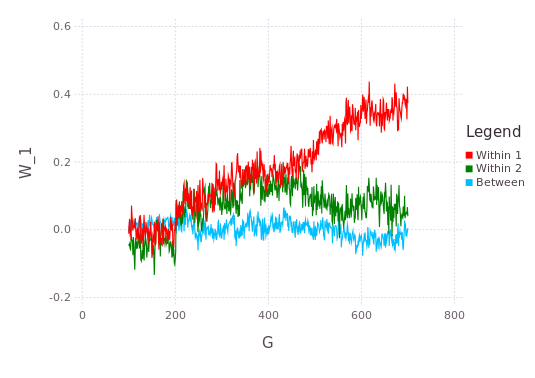

In [49]:
plot_corr = plotCorrelations(random_pop, 100)

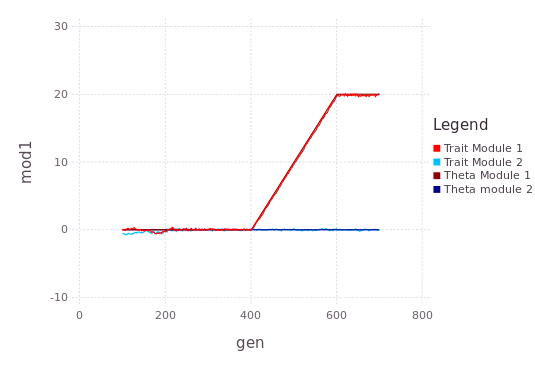

In [46]:
plot_traits = plotTraits(random_pop, 100)

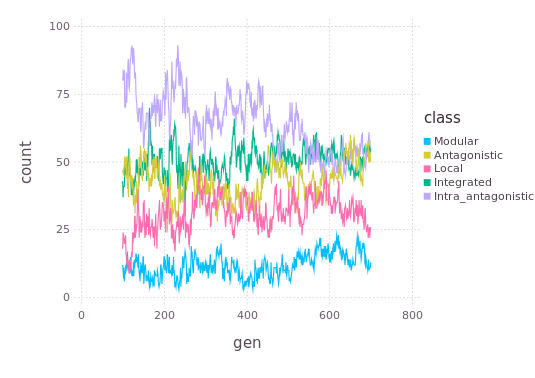

In [47]:
plot_pleio = plotPleitropy(random_pop, 100)

In [ ]:
draw(PDF("./figures/plot_pleioVectors_divergent.pdf", 6inch, 6inch), vstack(plot_corr, plot_traits, plot_pleio))

In [ ]:
b = random_pop.moments[end]["mean_b"]
clss = classifyBj(convert(Array{Int64, 2}, round(Int64, b)))

b_j = b[:,1]

In [ ]:
round(Int64, -0.6)